## Fake News Classification Project

Dataset shape: (44680, 4)
                                               title  \
0               Earthquake hits off Papua New Guinea   
1  CINDY MCCAIN Reportedly Accepts Trump Administ...   
2  Prosecutors say ex-House Speaker Hastert sexua...   
3  Romanian protesters halt building of Xmas fair...   
4  Congo elected to U.N. rights council; Britain,...   

                                                text                 date  \
0  LONDON (Reuters) - A magnitude 5.9 earthquake ...  September 17, 2017    
1  The Hill released controversial comments sore ...         Jun 12, 2017   
2  (Reuters) - Former U.S. House Speaker Dennis H...       April 9, 2016    
3  BUCHAREST (Reuters) - Romanian protesters clas...    December 2, 2017    
4  UNITED NATIONS (Reuters) - Democratic Republic...    October 16, 2017    

   is_fake  
0        0  
1        1  
2        0  
3        0  
4        0  
is_fake
1    23469
0    21211
Name: count, dtype: int64


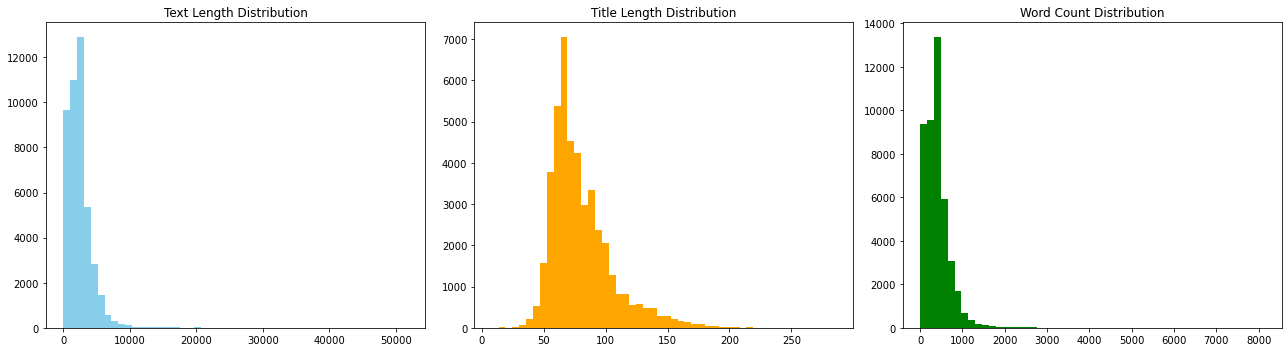

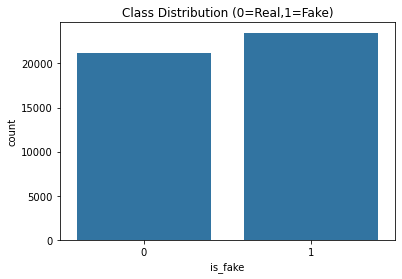

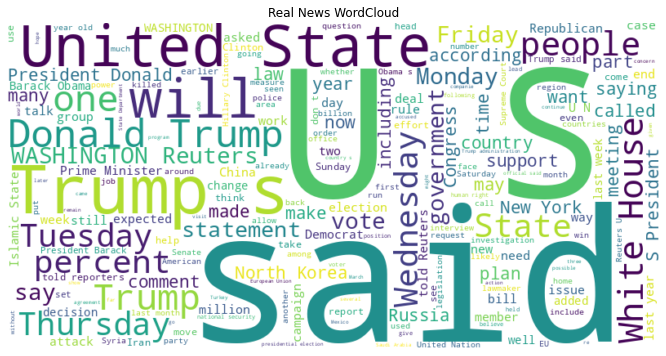

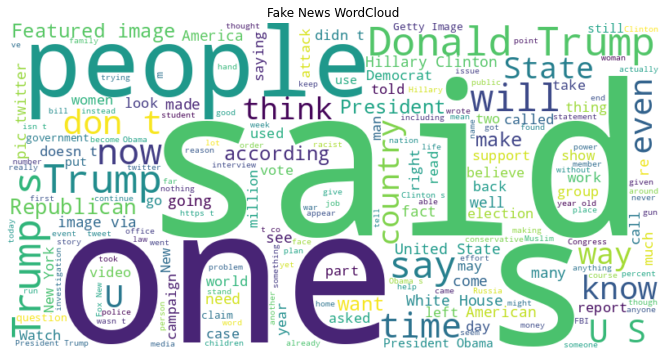

Preprocessing text...
Baseline F1: 0.6887747615553925
Baseline Accuracy: 0.5252909579230081
Logistic Regression F1: 0.9889874906447129
Accuracy: 0.9884735899731424
Random Forest F1: 0.9965848452508004
Accuracy: 0.9964189794091316
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Tuned LR F1: 0.9889874906447129
Accuracy: 0.9884735899731424
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Tuned RF F1: 0.9974397269042031
Accuracy: 0.9973142345568488
Ensemble F1: 0.9722103463018384
Accuracy: 0.9709042076991943
                 Model  F1-score  Accuracy
0             Baseline  0.688775  0.525291
1  Logistic Regression  0.988987  0.988474
2        Random Forest  0.996585  0.996419
3             Ensemble  0.972210  0.970904
4             LR Tuned  0.988987  0.988474
5             RF Tuned  0.997440  0.997314


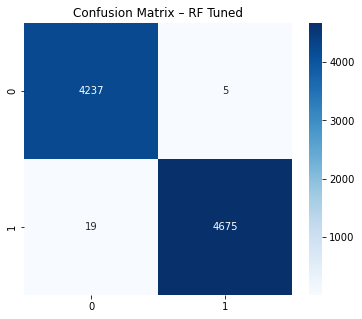

In [1]:
"""
Complete ML pipeline for Fake News Classification
Includes EDA, preprocessing, multiple models, hyperparameter tuning, and evaluation

- Fixed histogram + KDE plotting issues
- EDA plots (distributions, word clouds, class balance)
- Text preprocessing
- Baseline, LR, RF, tuned models, ensemble
- GridSearchCV hyperparameter tuning
- Clear results summary and confusion matrix
"""

# =========================
# 0. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from pathlib import Path

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# =========================
# 1. Load and Explore Data
# =========================
CSV_PATH = '/home/liubov/Téléchargements/fake_news_full_data.csv'
PREPROCESSED_FILE = Path("df_preprocessed.parquet")

df = pd.read_csv(CSV_PATH)

if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

print(f"Dataset shape: {df.shape}")
print(df.head())
print(df['is_fake'].value_counts())

# =========================
# 2. Text Statistics & EDA
# =========================
df['text_len'] = df['text'].str.len()
df['title_len'] = df['title'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Distributions
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].hist(df['text_len'].dropna(), bins=50, color='skyblue')
ax[0].set_title("Text Length Distribution")
ax[1].hist(df['title_len'].dropna(), bins=50, color='orange')
ax[1].set_title("Title Length Distribution")
ax[2].hist(df['word_count'].dropna(), bins=50, color='green')
ax[2].set_title("Word Count Distribution")
plt.tight_layout()
plt.show()

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_fake')
plt.title("Class Distribution (0=Real,1=Fake)")
plt.show()

# Wordclouds per class
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(df[df['is_fake']==0]['text'].astype(str), "Real News WordCloud")
plot_wordcloud(df[df['is_fake']==1]['text'].astype(str), "Fake News WordCloud")

# =========================
# 3. Text Preprocessing
# =========================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w)>2]
    return ' '.join(tokens)

if not PREPROCESSED_FILE.exists():
    print("Preprocessing text...")
    df['text_clean'] = df['text'].apply(preprocess_text)
    df['title_clean'] = df['title'].apply(preprocess_text)
    df['combined_text'] = df['title_clean'] + " " + df['text_clean']
    df.to_parquet(PREPROCESSED_FILE, index=False)
else:
    print("Loading preprocessed file...")
    df = pd.read_parquet(PREPROCESSED_FILE)

# =========================
# 4. Train-Test Split
# =========================
X = df['combined_text']
y = df['is_fake']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 5. Baseline
# =========================
y_baseline = np.ones(len(y_test)) * y_train.mode()[0]
print("Baseline F1:", f1_score(y_test, y_baseline))
print("Baseline Accuracy:", accuracy_score(y_test, y_baseline))

# =========================
# 6. Logistic Regression + TF-IDF
# =========================
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression F1:", f1_score(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# =========================
# 7. Random Forest + CountVectorizer
# =========================
cv = CountVectorizer(max_features=5000, ngram_range=(1,2), min_df=5)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_cv, y_train)
y_pred_rf = rf.predict(X_test_cv)

print("Random Forest F1:", f1_score(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# =========================
# 8. Hyperparameter Tuning with GridSearchCV
# =========================
# Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

lr_params = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [3, 5],
    'clf__C': [0.1, 1],
    'clf__penalty': ['l2']
}

lr_grid = GridSearchCV(lr_pipeline, lr_params, scoring='f1', cv=3, n_jobs=-1, verbose=2)
lr_grid.fit(X_train, y_train)

y_pred_lr_gs = lr_grid.predict(X_test)
print("Tuned LR F1:", f1_score(y_test, y_pred_lr_gs))
print("Accuracy:", accuracy_score(y_test, y_pred_lr_gs))

# Random Forest
rf_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_params = {
    'cv__max_features': [3000, 5000],
    'cv__ngram_range': [(1,1), (1,2)],
    'cv__min_df': [3, 5],
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, scoring='f1', cv=3, n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)

y_pred_rf_gs = rf_grid.predict(X_test)
print("Tuned RF F1:", f1_score(y_test, y_pred_rf_gs))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_gs))

# =========================
# 9. Ensemble
# =========================
nb = MultinomialNB()
ensemble = VotingClassifier(estimators=[('lr', lr), ('nb', nb)], voting='soft')
ensemble.fit(X_train_tfidf, y_train)
y_pred_ens = ensemble.predict(X_test_tfidf)

print("Ensemble F1:", f1_score(y_test, y_pred_ens))
print("Accuracy:", accuracy_score(y_test, y_pred_ens))

# =========================
# 10. Results Summary
# =========================
results = pd.DataFrame({
    "Model": ["Baseline", "Logistic Regression", "Random Forest", "Ensemble", "LR Tuned", "RF Tuned"],
    "F1-score": [f1_score(y_test, y_baseline),
                 f1_score(y_test, y_pred_lr),
                 f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_ens),
                 f1_score(y_test, y_pred_lr_gs),
                 f1_score(y_test, y_pred_rf_gs)],
    "Accuracy": [accuracy_score(y_test, y_baseline),
                 accuracy_score(y_test, y_pred_lr),
                 accuracy_score(y_test, y_pred_rf),
                 accuracy_score(y_test, y_pred_ens),
                 accuracy_score(y_test, y_pred_lr_gs),
                 accuracy_score(y_test, y_pred_rf_gs)]
})

print(results)

# =========================
# 11. Confusion Matrix for Best Model
# =========================
best_idx = results["F1-score"].idxmax()
best_model_name = results.loc[best_idx, "Model"]

if best_model_name in ["Logistic Regression", "LR Tuned"]:
    y_pred_best = y_pred_lr_gs
elif best_model_name in ["Random Forest", "RF Tuned"]:
    y_pred_best = y_pred_rf_gs
else:
    y_pred_best = y_pred_ens

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()


In [2]:
if BERT_AVAILABLE:
    print("\n" + "="*60)
    print("MODEL 6: BERT FINE-TUNING")
    print("="*60)

    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __len__(self): return len(self.texts)
        def __getitem__(self, idx):
            enc = self.tokenizer.encode_plus(
                self.texts.iloc[idx],
                max_length=self.max_len,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )
            return {
                'input_ids': enc['input_ids'].squeeze(),
                'attention_mask': enc['attention_mask'].squeeze(),
                'labels': torch.tensor(self.labels.iloc[idx])
            }

    N = 1000
    X_train_b = X_train.head(N).reset_index(drop=True)
    y_train_b = y_train.head(N).reset_index(drop=True)
    X_test_b = X_test.head(200).reset_index(drop=True)
    y_test_b = y_test.head(200).reset_index(drop=True)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    train_loader = DataLoader(NewsDataset(X_train_b, y_train_b, tokenizer), batch_size=16, shuffle=True)
    test_loader = DataLoader(NewsDataset(X_test_b, y_test_b, tokenizer), batch_size=16)

    device = get_device()
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)

    epochs = 2
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()

            ids = batch['input_ids'].to(device)
            ms = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            out = model(ids, attention_mask=ms, labels=labels)
            loss = out.loss
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=float(loss))

    # Evaluation
    model.eval()
    preds = []
    truth = []
    for batch in tqdm(test_loader, desc="Evaluating BERT"):
        ids = batch['input_ids'].to(device)
        ms = batch['attention_mask'].to(device)
        labels = batch['labels']

        with torch.no_grad():
            logits = model(ids, attention_mask=ms).logits

        p = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        preds.extend(p)
        truth.extend(labels.numpy().tolist())

    bert_f1 = f1_score(truth, preds)
    bert_acc = accuracy_score(truth, preds)
else:
    bert_f1 = 0
    bert_acc = 0

NameError: name 'BERT_AVAILABLE' is not defined

[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=3000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   4.7s
[CV] END clf__C=1, clf__penalty=l2, tfidf__max_features=3000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   6.2s
[CV] END clf__C=1, clf__penalty=l2, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   6.1s
[CV] END clf__C=1, clf__penalty=l2, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   6.2s
[CV] END clf__C=1, clf__penalty=l2, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=  18.1s
[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=200, cv__max_features=5000, cv__min_df=5, cv__ngram_range=(1, 2); total time=  40.6s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=200, cv__max_features=3000, cv__min_df=3, cv__ngram_range=(1, 1); total time=  15.3s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__